# 사과 종 분류 과제

## 데이터 구조

```
$ DATA/
├── train/
│   ├── xxx.jpg
│   ├── yyy.jpg
│   └── zzz.jpg
├── test/
│   ├── xxx.jpg
│   ├── yyy.jpg
│   └── zzz.jpg
├── train.csv
├── test.csv
├── sample_submission.csv
├── train_labels.csv (코드 실행 후 생성)
└── valid_labels.csv (코드 실행 후 생성)
```



## 0. 사전 준비

### 구글 드라이브 마운트

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive



### 데이터 압축 풀기

In [2]:
import os
os.chdir('/content/drive/MyDrive/apple_classification/DATA')

In [ ]:
# !unzip train_all.zip

In [ ]:
# !unzip test.zip

### 필요 라이브러리 설치

In [3]:
!pip install timm
!pip install -U scikit-learn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 549 kB 6.3 MB/s 
     |████████████████████████████████| 182 kB 35.8 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## 1. 라이브러리 불러오기

In [4]:
from torch.utils.data import DataLoader
import torch

from datetime import datetime, timezone, timedelta
import numpy as np
import random
import os
import copy

import pandas as pd
import matplotlib.pyplot as plt

from torch.utils.data import Dataset
from PIL import Image
import torchvision.transforms as transforms

from sklearn.model_selection import train_test_split
from tqdm import tqdm
import random

import timm
from torch import nn

from sklearn.metrics import accuracy_score, f1_score
from PIL import Image

## 2. 경로 / 기타 인자 설정

### 데이터 경로 설정

In [5]:
# 프로젝트 경로
PROJECT_DIR = '/content/drive/MyDrive/apple_classification'
os.chdir(PROJECT_DIR)

# 데이터 경로
DATA_DIR = os.path.join(PROJECT_DIR, 'DATA')
# TRAIN_IMG_DIR = os.path.join(DATA_DIR, 'train')
TRAIN_IMG_DIR = os.path.join(DATA_DIR, 'train_all')
# TRAIN_LABEL_DIR = os.path.join(DATA_DIR, 'train.csv')
TRAIN_LABEL_DIR = os.path.join(DATA_DIR, 'train_all.csv')
TEST_IMG_DIR = os.path.join(DATA_DIR, 'test')
TEST_LABEL_DIR = os.path.join(DATA_DIR, 'test.csv')
SAMPLE_DIR = os.path.join(DATA_DIR, 'sample_submission.csv')

In [6]:
# 파일 수 확인 
print(len(os.listdir(TRAIN_IMG_DIR)))
print(len(os.listdir(TEST_IMG_DIR)))

print(len(os.listdir('/content/drive/MyDrive/apple_classification/DATA/train_all')))

14000
5000
14000


### 결과 저장 경로 설정

In [7]:
# 시간 고유값 
kst = timezone(timedelta(hours=9))        
train_serial = datetime.now(tz=kst).strftime("%Y%m%d_%H%M%S")

# 기록 경로
RECORDER_DIR = os.path.join(PROJECT_DIR, 'results', 'train', train_serial)
# 현재 시간 기준 폴더 생성
os.makedirs(RECORDER_DIR, exist_ok=True)    

In [8]:
RECORDER_DIR

'/content/drive/MyDrive/apple_classification/results/train/20221125_200807'

### 시드 설정

In [9]:
# 시드
RANDOM_SEED = 42
torch.manual_seed(RANDOM_SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)

### 디바이스 설정

In [9]:
# GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [10]:
device

device(type='cpu')

## 3. 데이터 불러오기 및 분할

### Image augmentaion

In [12]:
# 학습 파일
traindf = pd.read_csv(TRAIN_LABEL_DIR)

traindf.head()

,img_id,a_type
0,yVvIyEOqz8.jpg,HJ
1,HLdFN3ULg2.jpg,HJ
2,bAm1CUZtO8.jpg,HJ
3,n5hMUvCCV6.jpg,HR
4,9RiwdmWGSq.jpg,SG


In [10]:
# data augmention 을 위한 task

traindf['a_type'].value_counts()

HJ    5325
HR    3049
SG     817
AR     809
Name: a_type, dtype: int64

In [11]:
dfSG=traindf[traindf['a_type']=='SG']
dfAR=traindf[traindf['a_type']=='AR']

In [ ]:
!pip3 install natsorted
!pip3 install Augmentor

In [13]:
import Augmentor
from natsort import natsorted

In [14]:

sg_images = [os.path.join(TRAIN_IMG_DIR, i) for i in dfSG['img_id']]
sg_labels = [os.path.join(TRAIN_IMG_DIR, i) for i in dfSG['a_type']]
ar_images = [os.path.join(TRAIN_IMG_DIR, i) for i in dfAR['img_id']]
arg_labels = [os.path.join(TRAIN_IMG_DIR, i) for i in dfAR['a_type']]

In [240]:
# SG 이미지만 따로 저장 for aug

import cv2
from google.colab.patches import cv2_imshow
for i in range(len(sg_images)):
  img = cv2.imread(sg_images[i]) 
  cv2.imwrite('/content/drive/MyDrive/apple_classification/DATA/train_SG/'+f'sg_{i}.jpg', img)

In [244]:
# AR 이미지만 따로 저장 for aug

for i in range(len(ar_images)):
  img = cv2.imread(ar_images[i]) 
  cv2.imwrite('/content/drive/MyDrive/apple_classification/DATA/train_AR/'+f'ar_{i}.jpg', img)

In [18]:
# a = Augmentor.DataPipeline(images,list(dfSG['a_type']))

sg = Augmentor.Pipeline("/content/drive/MyDrive/apple_classification/DATA/train_SG")
ar = Augmentor.Pipeline("/content/drive/MyDrive/apple_classification/DATA/train_AR")

Initialised with 817 image(s) found.
Output directory set to /content/drive/MyDrive/apple_classification/DATA/train_SG/output.Initialised with 809 image(s) found.
Output directory set to /content/drive/MyDrive/apple_classification/DATA/train_AR/output.

In [19]:
sg.flip_left_right(probability=0.5)
sg.flip_top_bottom(probability=0.5)
sg.rotate90(probability=0.5)
sg.rotate270(probability=0.5)
sg.random_distortion(probability=1, grid_width=4, grid_height=4, magnitude=8)
sg.sample(2000)

ar.flip_left_right(probability=0.5)
ar.flip_top_bottom(probability=0.5)
ar.rotate90(probability=0.5)
ar.rotate270(probability=0.5)
ar.random_distortion(probability=1, grid_width=4, grid_height=4, magnitude=8)
ar.sample(2000)



Processing <PIL.Image.Image image mode=RGB size=512x512 at 0x7FC932594690>: 100%|██████████| 2000/2000 [00:59<00:00, 33.66 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=512x512 at 0x7FC92CD52A10>: 100%|██████████| 2000/2000 [01:01<00:00, 32.38 Samples/s]


In [24]:
dist_sg_image=os.listdir('/content/drive/MyDrive/apple_classification/DATA/train_SG/output')
dist_ar_image=os.listdir('/content/drive/MyDrive/apple_classification/DATA/train_AR/output')

In [28]:
sg_images2 = [os.path.join('/content/drive/MyDrive/apple_classification/DATA/train_SG/output', i) for i in dist_sg_image]
ar_images2 = [os.path.join('/content/drive/MyDrive/apple_classification/DATA/train_AR/output', i) for i in dist_ar_image]

In [ ]:
sg_images2

In [34]:
sg=pd.DataFrame({"img_id":dist_sg_image,
              "a_type":["SG"]*len(dist_sg_image)})

In [37]:
ar=pd.DataFrame({"img_id":dist_ar_image,
              "a_type":["AR"]*len(dist_ar_image)})

In [39]:
ar.to_csv(os.path.join(DATA_DIR, 'train_ar.csv'), index=False)


In [59]:
# traindf 와 sg, ar concat
concat_df_sg=pd.concat([traindf,sg])
df=pd.concat([concat_df_sg,ar])

In [60]:
# index reset

traindf=df.reset_index(drop=True)

### Train 라벨

In [13]:
# Image augmentation 된 csv read

# traindf.to_csv(os.path.join(DATA_DIR, 'train_all.csv'), index=False)
traindf = pd.read_csv(TRAIN_LABEL_DIR)

traindf.head()

,img_id,a_type
0,yVvIyEOqz8.jpg,HJ
1,HLdFN3ULg2.jpg,HJ
2,bAm1CUZtO8.jpg,HJ
3,n5hMUvCCV6.jpg,HR
4,9RiwdmWGSq.jpg,SG


In [14]:
traindf

,img_id,a_type
0,yVvIyEOqz8.jpg,HJ
1,HLdFN3ULg2.jpg,HJ
2,bAm1CUZtO8.jpg,HJ
3,n5hMUvCCV6.jpg,HR
4,9RiwdmWGSq.jpg,SG
...,...,...
13995,train_AR_original_ar_151.jpg_d358a728-c59b-464...,AR
13996,train_AR_original_ar_100.jpg_ea022080-f083-412...,AR
13997,train_AR_original_ar_451.jpg_6ac3bb42-4cbc-4f2...,AR
13998,train_AR_original_ar_536.jpg_c78cc4c5-e9b1-41e...,AR


### Train 이미지 예시

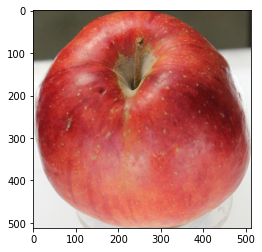

In [76]:
# 이미지 예시
example_index = random.randrange(len(traindf)) # 0,1,2,...
example_imageid = traindf['img_id'][example_index]
example_image_path = os.path.join(TRAIN_IMG_DIR, example_imageid)
example_image = Image.open(example_image_path)

plt.imshow(example_image)

### Train / Validation 분할

In [15]:
# 80% / 20% 비율로 분할
train,val = train_test_split(traindf, test_size=0.2, shuffle=True)

# train / validation로 나눈 데이터 프레임 저장
train.to_csv(os.path.join(DATA_DIR, 'train_labels.csv'), index=False)
val.to_csv(os.path.join(DATA_DIR, 'val_labels.csv'),index=False)

In [16]:
print(len(train))
print(len(val))

11200
2800


## 4. Dataset 

### Dataset 클래스 정의

In [17]:
class AppleDataset(Dataset):
  def __init__(self, img_folder, labelpath):
    self.df = pd.read_csv(labelpath, usecols=['img_id','a_type'],dtype={'a_type':str})
    self.label_encoding = {'HJ':0, 'HR':1, 'SG':2, 'AR':3}
    self.img_folder = img_folder
    self.transforms = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
    ])  
    self.img_ids = list(self.df['img_id'])
    self.labels = list(self.df['a_type'])
  
  def __len__(self):
    return len(self.img_ids)

  def __getitem__(self, index):
    impath = os.path.join(self.img_folder, self.img_ids[index])
    img = Image.open(impath)
    img = self.transforms(img)
    lbl = self.labels[index]
    lbl = self.label_encoding[lbl]
    return img,lbl


## 5. 모델 정의

### 모델 Class 생성

In [16]:
F = nn.functional

class CustomNet(nn.Module):
  def __init__(self):
    super(CustomNet, self).__init__()
    # 합성곱 층
    self.conv1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=3)
    self.pool1 = nn.MaxPool2d(2,2)
    self.conv2 = nn.Conv2d(6,3,3,4)
    self.pool2 = nn.MaxPool2d(2,2)
    self.conv3 = nn.Conv2d(3,3,3,padding=1)

    # 완전 연결 층
    self.fc1 = nn.Linear(3072, 1036)
    self.fc2 = nn.Linear(1036, 518)
    self.fc3 = nn.Linear(518, 4)

  def forward(self, x):
    x = self.pool1(F.relu(self.conv1(x)))
    x = self.pool2(F.relu(self.conv2(x)))
    x = F.relu(self.conv3(x))
    x = torch.flatten(x, 1) 
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    output = self.fc3(x)   
    return output
  
class EffNet(nn.Module):
  def __init__(self):
    super(EffNet, self).__init__()
    self.model = timm.create_model('efficientnet_b4', pretrained=True)
    self.model.classifier = nn.Sequential(
        nn.Linear(in_features = 1792, out_features = 625),
        nn.ReLU(),
        nn.Dropout(p=0.4),
        nn.Linear(625,256),
        nn.ReLU(),
        nn.Linear(256, 4)
    )
    for param in self.model.parameters():
      param.requires_grad = False
    for param in self.model.classifier.parameters():
      param.requires_grad = True
  
  def forward(self, x):
    output = self.model(x)
    return output

### 모델 선택 함수

In [14]:
def get_model(model_name:str):
  if model_name == 'Custom':
    return CustomNet()
  if model_name == 'effnet':
    return EffNet()

## 6. 학습

### DataLoader 관련 인자 설정

In [20]:
# Dataloader 관련 인자
BATCH_SIZE = 16
NUM_WORKERS = 1
SHUFFLE = True
PIN_MEMORY = True
DROP_LAST = False

### Dataset 및 DataLoader 생성



In [21]:
# 데이터 셋 정의
train_dataset = AppleDataset(img_folder = TRAIN_IMG_DIR, labelpath = os.path.join(DATA_DIR,'train_labels.csv'))
valid_dataset = AppleDataset(img_folder = TRAIN_IMG_DIR, labelpath = os.path.join(DATA_DIR,'val_labels.csv'))

# 데이터 로더 정의
train_dataloader = DataLoader(dataset = train_dataset,
                              batch_size = BATCH_SIZE,
                              num_workers = NUM_WORKERS,
                              shuffle = SHUFFLE,
                              pin_memory = PIN_MEMORY,
                              drop_last = DROP_LAST)

valid_dataloader = DataLoader(dataset = valid_dataset,
                              batch_size = BATCH_SIZE,
                              num_workers = NUM_WORKERS,
                              shuffle = SHUFFLE,
                              pin_memory = PIN_MEMORY,
                              drop_last = DROP_LAST)

In [22]:
len(train_dataset)

11200

In [23]:
len(valid_dataset)

2800

### 모델 설정

In [25]:
# Hyperparameter 설정
LEARNING_RATE = 0.0005
EPOCHS = 20

In [13]:
# 모델 불러오기
model = get_model('effnet')
model.to(device)

# Loss와 optimizer 설정
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = LEARNING_RATE)

NameError: ignored

### 학습 진행

In [27]:
best_loss = np.Inf

for epoch in range(EPOCHS):
  ### 학습 ###
  model.train()  # 모델 학습 적용
  
  train_total_loss = 0
  target_list = [] # 실제 사과 종 추가할 리스트 
  pred_list = []  # 예측 사과 종 추가할 리스트
  
  # train
  for batch_index, (x,y) in tqdm(enumerate(train_dataloader)):
    x,y = x.to(device), y.to(device)                          # x - image data, y - 실제 label을 GPU로 옮김 
    y_pred = model(x)                                         # 모델을 통해 나온 output
    loss = criterion(y_pred, y)                               # 실제값 y와 예측값 y_pred로 loss 계산
    optimizer.zero_grad()                                     # optimizer 초기화
    loss.backward()                                           # gradient 계산
    optimizer.step()                                          # 역전파
    train_total_loss += loss.item()                           # train_total_loss에 loss값을 누적
    pred_list.extend(y_pred.argmax(dim=1).cpu().tolist())     # 예측한 값중 가장 높은 값의 인덱스를 추가
    target_list.extend(y.cpu().tolist())                      # 실제 label 인덱스를 추가 
  train_mean_loss = train_total_loss / batch_index            # 에폭의 평균 loss
  train_accuracy = accuracy_score(target_list, pred_list)     # accuracy_score
  train_f1score = f1_score(target_list, pred_list, average='macro')  # macro - f1 Score
  
  ### 검증 ###
  model.eval()                                                # 학습 모드를 검증 모드로 변경
  val_total_loss = 0                                          
  target_list = []                                            
  pred_list = []
  with torch.no_grad():                                       # 역전파 하지 않음
    for batch_index, (x,y) in tqdm(enumerate(valid_dataloader)):    
      x = x.to(device)                                         
      y = y.to(device)
      y_pred = model(x)
      loss = criterion(y_pred, y)
      #
      val_total_loss += loss.item()
      target_list.extend(y.cpu().tolist())
      pred_list.extend(y_pred.argmax(dim=1).cpu().tolist())
  val_mean_loss = val_total_loss / batch_index
  val_accuracy = accuracy_score(target_list, pred_list)
  val_f1score = f1_score(target_list, pred_list, average='macro')

  msg1 = f"Epoch {epoch}/{EPOCHS} - Train loss: {train_mean_loss}; Train Accuracy: {train_accuracy}; Train F1: {train_f1score}"
  msg2 = f"Valid loss: {val_mean_loss}; Val Accuracy: {val_accuracy}; Val F1: {val_f1score}"
  print(msg1)
  print(msg2)

  ### 결과 저장 ###
  # validation loss가 개선될 때 모델 저장
  if val_mean_loss < best_loss:                               
    best_loss = val_mean_loss
    check_point = {                                         
        'model': model.state_dict(),
        'optimizer': optimizer.state_dict(),
    }
    torch.save(check_point, os.path.join(RECORDER_DIR,f'loss:{best_loss : .3f},f1score:{val_f1score : .3f},best.pt')) 


700it [1:11:33,  6.13s/it]
175it [20:10,  6.92s/it]


Epoch 0/20 - Train loss: 0.2987104583203857; Train Accuracy: 0.8875; Train F1: 0.8820691555131792
Valid loss: 0.13604537751953835; Val Accuracy: 0.9517857142857142; Val F1: 0.95065025554762


700it [03:29,  3.33it/s]
175it [00:48,  3.64it/s]


Epoch 1/20 - Train loss: 0.15931288034652488; Train Accuracy: 0.9414285714285714; Train F1: 0.9382749817566604
Valid loss: 0.11658609140230793; Val Accuracy: 0.9585714285714285; Val F1: 0.9571487296427346


700it [03:30,  3.33it/s]
175it [00:48,  3.64it/s]


Epoch 2/20 - Train loss: 0.12218188776855139; Train Accuracy: 0.9554464285714286; Train F1: 0.9532043873686631
Valid loss: 0.10629584741860296; Val Accuracy: 0.9621428571428572; Val F1: 0.9608763375348988


700it [03:30,  3.33it/s]
175it [00:49,  3.55it/s]


Epoch 3/20 - Train loss: 0.1140565853037982; Train Accuracy: 0.9584821428571428; Train F1: 0.9563137645211894
Valid loss: 0.09824383376389019; Val Accuracy: 0.9603571428571429; Val F1: 0.9585468686588441


700it [03:30,  3.32it/s]
175it [00:48,  3.63it/s]

Epoch 4/20 - Train loss: 0.0929227559369268; Train Accuracy: 0.9661607142857143; Train F1: 0.9642537500532449
Valid loss: 0.12437537079024659; Val Accuracy: 0.9578571428571429; Val F1: 0.957200620449506



700it [03:31,  3.30it/s]
175it [00:48,  3.63it/s]


Epoch 5/20 - Train loss: 0.0762387607475221; Train Accuracy: 0.97125; Train F1: 0.96981107048953
Valid loss: 0.08519447092990519; Val Accuracy: 0.9685714285714285; Val F1: 0.9675095162971843


700it [03:30,  3.32it/s]
175it [00:48,  3.64it/s]


Epoch 6/20 - Train loss: 0.07819946734165574; Train Accuracy: 0.9715178571428571; Train F1: 0.9700572569484587
Valid loss: 0.08472176204802169; Val Accuracy: 0.9714285714285714; Val F1: 0.970234472688579


700it [03:30,  3.33it/s]
175it [00:49,  3.53it/s]


Epoch 7/20 - Train loss: 0.06588280507526927; Train Accuracy: 0.9785714285714285; Train F1: 0.9777401572344322
Valid loss: 0.07939681307654882; Val Accuracy: 0.9746428571428571; Val F1: 0.9741154081116128


700it [03:31,  3.30it/s]
175it [00:48,  3.63it/s]

Epoch 8/20 - Train loss: 0.05569772537217611; Train Accuracy: 0.9795535714285715; Train F1: 0.9787215301914121
Valid loss: 0.08923007296801387; Val Accuracy: 0.9707142857142858; Val F1: 0.9699573164017492



700it [03:30,  3.33it/s]
175it [00:48,  3.63it/s]

Epoch 9/20 - Train loss: 0.05320425822202367; Train Accuracy: 0.9802678571428571; Train F1: 0.9790237113023049
Valid loss: 0.08812328425585877; Val Accuracy: 0.9721428571428572; Val F1: 0.9709121642225305



700it [03:30,  3.33it/s]
175it [00:48,  3.63it/s]

Epoch 10/20 - Train loss: 0.044372586830419544; Train Accuracy: 0.9842857142857143; Train F1: 0.9832077603149356
Valid loss: 0.08176732489795248; Val Accuracy: 0.9732142857142857; Val F1: 0.972403226541943



700it [03:30,  3.33it/s]
175it [00:49,  3.56it/s]


Epoch 11/20 - Train loss: 0.054849234604753994; Train Accuracy: 0.9801785714285715; Train F1: 0.9793496416354118
Valid loss: 0.07513424950288361; Val Accuracy: 0.9732142857142857; Val F1: 0.9720491674634302


700it [03:30,  3.33it/s]
175it [00:48,  3.63it/s]

Epoch 12/20 - Train loss: 0.04267127966188169; Train Accuracy: 0.9841071428571428; Train F1: 0.9831347996653592
Valid loss: 0.07618486226829714; Val Accuracy: 0.9728571428571429; Val F1: 0.9720494067976109



700it [03:30,  3.33it/s]
175it [00:48,  3.63it/s]

Epoch 13/20 - Train loss: 0.03679933419628759; Train Accuracy: 0.9875892857142857; Train F1: 0.9866742931127386
Valid loss: 0.09164510216894202; Val Accuracy: 0.9714285714285714; Val F1: 0.9709461982293608



700it [03:30,  3.33it/s]
175it [00:48,  3.63it/s]

Epoch 14/20 - Train loss: 0.04116366069205891; Train Accuracy: 0.9858928571428571; Train F1: 0.9850480634253169
Valid loss: 0.08499003545474462; Val Accuracy: 0.9703571428571428; Val F1: 0.9693099238228131



700it [03:30,  3.33it/s]
175it [00:48,  3.64it/s]

Epoch 15/20 - Train loss: 0.03816510263605337; Train Accuracy: 0.9875892857142857; Train F1: 0.9870546546376306
Valid loss: 0.07679422351727759; Val Accuracy: 0.9753571428571428; Val F1: 0.9745506822685648



700it [03:30,  3.33it/s]
175it [00:49,  3.56it/s]

Epoch 16/20 - Train loss: 0.036942285443407524; Train Accuracy: 0.98625; Train F1: 0.9856547157721092
Valid loss: 0.10856490758341555; Val Accuracy: 0.9692857142857143; Val F1: 0.9688251409324868



700it [03:30,  3.33it/s]
175it [00:48,  3.64it/s]

Epoch 17/20 - Train loss: 0.036578715337978816; Train Accuracy: 0.9864285714285714; Train F1: 0.9859045223219806
Valid loss: 0.09425122727019823; Val Accuracy: 0.9707142857142858; Val F1: 0.9700223207481291



700it [03:30,  3.33it/s]
175it [00:48,  3.64it/s]

Epoch 18/20 - Train loss: 0.030580920093693235; Train Accuracy: 0.9882142857142857; Train F1: 0.9874179416187805
Valid loss: 0.09059781718036086; Val Accuracy: 0.9717857142857143; Val F1: 0.9704155745996899



700it [03:30,  3.33it/s]
175it [00:48,  3.64it/s]


Epoch 19/20 - Train loss: 0.03768899494586311; Train Accuracy: 0.9866964285714286; Train F1: 0.9856985075650868
Valid loss: 0.07483920233984274; Val Accuracy: 0.9771428571428571; Val F1: 0.9763622532963724


## 7. 추론

### 데이터 셋 설정

In [12]:
class TestDataset(Dataset):
  def __init__(self, img_folder, labelpath):
    self.df = pd.read_csv(labelpath , usecols=['img_id'],dtype={'img_id':str})
    self.img_folder = img_folder
    self.transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])
    self.img_ids = list(self.df['img_id'])
      
  def __len__(self):
    return len(self.img_ids)
  
  def __getitem__(self, index):
    impath = os.path.join(self.img_folder, self.img_ids[index])
    img = Image.open(impath)
    img = self.transforms(img)
    img_ids = self.img_ids[index]
    
    return img,img_ids

#### 모델설정

In [ ]:
# 모델 Load
model = get_model('effnet')
checkpoint = torch.load(os.path.join('/content/drive/MyDrive/apple_classification/results/train/20221125_163611/loss: 0.079,f1score: 0.974,best.pt'),map_location=torch.device('cpu'))
model.load_state_dict(checkpoint['model'])
model.to(device)

### Dataset 및 DataLoader 설정

In [34]:
# Dataloader 관련 인자
BATCH_SIZE = 1
NUM_WORKERS = 1
SHUFFLE = False
PIN_MEMORY = True
DROP_LAST = False

In [35]:
# Dataset
test_dataset = TestDataset(img_folder = TEST_IMG_DIR, labelpath = os.path.join(TEST_LABEL_DIR))


# DataLoader
test_dataloader = DataLoader(dataset = test_dataset,
                              batch_size = BATCH_SIZE,
                              num_workers = NUM_WORKERS,
                              shuffle = SHUFFLE,
                              pin_memory = PIN_MEMORY,
                              drop_last = DROP_LAST)

### 추론 진행

In [ ]:
model.eval()      # 학습 모드를 검증 모드로 변경

# 예측 진행
y_preds = []
img_ids = []

for batch_index, (x, img_id) in enumerate(tqdm(test_dataloader)):
    x = x.to(device, dtype=torch.float)
    y_logits = model(x).cpu()
    y_pred = torch.argmax(y_logits, dim=1)
    y_pred = y_pred.cpu().tolist()
    img_ids.extend(img_id)
    y_preds.extend(y_pred)

 12%|█▏        | 591/5000 [08:04<57:18,  1.28it/s]

### 추론 결과 저장

In [ ]:
# 결과 데이터 프레임 생성 및 라벨 디코딩
pred_df = pd.DataFrame(list(zip(img_ids, y_preds)), columns=['img_id','a_type'])
label_decoding = {0:'HJ', 1:'HR', 2:'SG', 3:'AR'}
pred_df['a_type'] = pred_df['a_type'].replace(label_decoding)

In [ ]:
# 샘플과 동일한 순서로 변경
sample_df = pd.read_csv(SAMPLE_DIR)
sorter = list(sample_df['img_id'])
resdf = pred_df.set_index('img_id')
result = resdf.loc[sorter].reset_index()

In [ ]:
result

In [24]:
# result.to_csv(os.path.join(RECORDER_DIR,'result0972.csv'),index=False)

In [ ]:
result.to_csv(os.path.join(RECORDER_DIR,'result0974.csv'),index=False)